In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,image_fn
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']
...,...,...,...,...
1113,Glastrier,896,Ice,['896']
1114,Spectrier,897,Ghost,['897']
1115,Calyrex,898,Psychic,['898_1']
1116,Calyrex Ice Rider,898,Psychic,['898_2']


- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


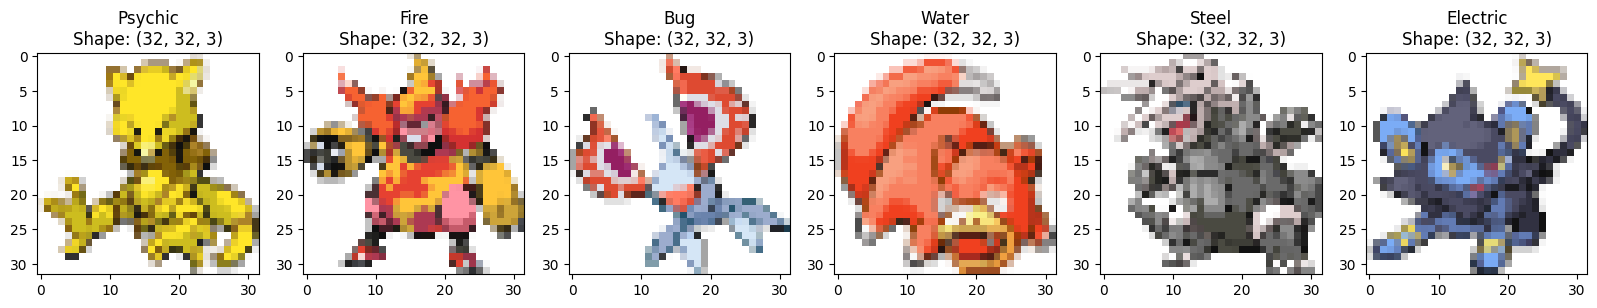

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
# from src.model.build_unet_copy import build_unet

u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1715126708.735244  140172 service.cc:145] XLA service 0x77e768003260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715126708.735283  140172 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715126709.227974  140172 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715126711.859101  140297 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5845', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1715126712.481759  140311 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5845', 428 bytes spill stores, 428 bytes spill loads



 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.1667  

I0000 00:00:1715126719.771087  140172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 0.9967
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9852
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9839
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9711
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9474
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9354
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9186
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9156
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9174
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9097
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9155
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9095
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9073
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9083
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8981


Sampling sprite: 500it [00:25, 19.45it/s]                         


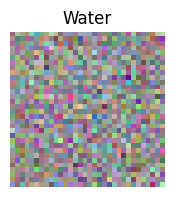

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - loss: 0.8991
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8989
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8949
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8968
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8986
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9005
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8973
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8947
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8913
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8961
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.9037
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8953
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8970
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8980
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss

Sampling sprite: 500it [00:24, 20.71it/s]                         


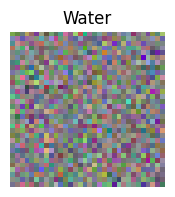

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - loss: 0.8963
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8903
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8914
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8916
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8944
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8850
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8920
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8884
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8943
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8882
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8877
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8914
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8920
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8929
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss

Sampling sprite: 500it [00:25, 19.96it/s]                         


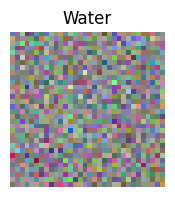

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - loss: 0.8920
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8905
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8893
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8900
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8873
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8918
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8914
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.8870
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8871
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8901
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.8885
Epoch 71/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.8878

In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

[BACK TO TOP](#top)